In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [2]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_mujoco_ant',
 'd4rl_mujoco_halfcheetah',
 'dart',
 'davis',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiab

In [3]:
train_split, valid_split = ['train[:90%]', 'train[90%:]']
train_data, info = tfds.load("cifar10", split=train_split, with_info=True)
valid_data = tfds.load("cifar10", split=valid_split)
test_data = tfds.load("cifar10", split="test")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to C:\Users\rocky\tensorflow_datasets\cifar10\3.0.2. Subsequent calls will reuse this data.


In [4]:
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='C:\\Users\\rocky\\tensorflow_datasets\\cifar10\\3.0.2',
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning

In [5]:
labels_dict = dict(enumerate(info.features['label'].names))
labels_dict

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [6]:
train_dict = {}
for data in train_data:
    label = data['label'].numpy()
    train_dict[label] = train_dict.setdefault(label, 0) + 1
print(train_dict)

{7: 4500, 8: 4456, 4: 4497, 6: 4505, 5: 4503, 2: 4522, 9: 4453, 3: 4526, 0: 4530, 1: 4508}


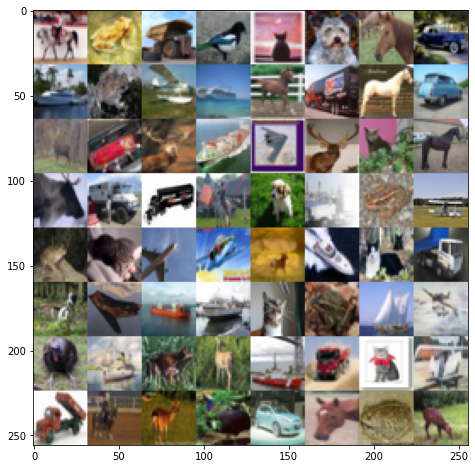

In [7]:
output = np.zeros((32 * 8, 32 * 8, 3), dtype=np.uint8)
row = 0
for data in train_data.batch(8).take(8):
    output[:, row*32:(row+1)*32] = np.vstack(data['image'].numpy())
    row += 1
plt.figure(figsize=(8, 8))
plt.imshow(output)

In [8]:
def parse_fn(dataset):
    x = tf.cast(dataset['image'], tf.float32) / 255.
    y = tf.one_hot(dataset['label'], 10)
    return x, y

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式
batch_size = 64  # 批次大小
train_num = int(info.splits['train'].num_examples / 10) * 9  # 訓練資料數量

train_data = train_data.shuffle(train_num)  # 打散資料集
# 載入前面的資料愈處理function，cpu數量為自動調整模式
train_data = train_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入前面的資料愈處理function，cpu數量為自動調整模式
valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入前面的資料愈處理function，cpu數量為自動調整模式
test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [10]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Flatten()(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(10, activation='softmax')(x) 
model_1 = keras.Model(inputs, outputs, name='model-1')
model_1.summary()

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1315

In [11]:
model_dir = 'lab4-logs/models'
os.makedirs(model_dir)

In [12]:
log_dir = os.path.join('lab4-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir='lab4-logs/model-1')
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.hdf5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')

In [13]:
model_1.compile(keras.optimizers.Adam(), 
               loss=keras.losses.CategoricalCrossentropy(), 
               metrics=[keras.metrics.CategoricalAccuracy()])

In [14]:
history_1 = model_1.fit(train_data,
                        epochs=100, 
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp])

Epoch 1/100
704/704 [==============================] - 7s 7ms/step - loss: 2.1866 - categorical_accuracy: 0.1548 - val_loss: 2.1278 - val_categorical_accuracy: 0.1918
Epoch 2/100
704/704 [==============================] - 4s 5ms/step - loss: 2.1061 - categorical_accuracy: 0.1755 - val_loss: 2.0396 - val_categorical_accuracy: 0.2268
Epoch 3/100
704/704 [==============================] - 4s 5ms/step - loss: 2.0798 - categorical_accuracy: 0.1969 - val_loss: 2.0096 - val_categorical_accuracy: 0.2406
Epoch 4/100
704/704 [==============================] - 4s 5ms/step - loss: 2.0662 - categorical_accuracy: 0.2013 - val_loss: 2.0123 - val_categorical_accuracy: 0.2336
Epoch 5/100
704/704 [==============================] - 4s 5ms/step - loss: 2.0535 - categorical_accuracy: 0.2106 - val_loss: 2.0387 - val_categorical_accuracy: 0.2170 loss: 2.054
Epoch 6/100
704/704 [==============================] - 4s 5ms/step - loss: 2.0489 - categorical_accuracy: 0.2103 - val_loss: 1.9988 - val_categorical_acc

704/704 [==============================] - 4s 5ms/step - loss: 2.0186 - categorical_accuracy: 0.2229 - val_loss: 1.9967 - val_categorical_accuracy: 0.2356
Epoch 96/100
704/704 [==============================] - 4s 5ms/step - loss: 2.0225 - categorical_accuracy: 0.2163 - val_loss: 2.0046 - val_categorical_accuracy: 0.2478
Epoch 97/100
704/704 [==============================] - 4s 5ms/step - loss: 2.0438 - categorical_accuracy: 0.2157 - val_loss: 2.0223 - val_categorical_accuracy: 0.2460
Epoch 98/100
704/704 [==============================] - 4s 5ms/step - loss: 2.0402 - categorical_accuracy: 0.2145 - val_loss: 1.9960 - val_categorical_accuracy: 0.2354
Epoch 99/100
704/704 [==============================] - 4s 5ms/step - loss: 2.0121 - categorical_accuracy: 0.2284 - val_loss: 1.9767 - val_categorical_accuracy: 0.2606
Epoch 100/100
704/704 [==============================] - 4s 5ms/step - loss: 2.0083 - categorical_accuracy: 0.2287 - val_loss: 2.0054 - val_categorical_accuracy: 0.2372


In [15]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)
model_2 = keras.Model(inputs, outputs, name='model-2')
model_2.summary()

Model: "model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          7379

In [16]:
log_dir = os.path.join('lab4-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.hdf5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')

In [17]:
model_2.compile(keras.optimizers.Adam(), 
               loss=keras.losses.CategoricalCrossentropy(), 
               metrics=[keras.metrics.CategoricalAccuracy()])

In [18]:
history_2 = model_2.fit(train_data,
                        epochs=100, 
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp])

Epoch 1/100
704/704 [==============================] - 26s 19ms/step - loss: 1.8331 - categorical_accuracy: 0.3117 - val_loss: 1.4107 - val_categorical_accuracy: 0.4870 - ETA
Epoch 2/100
704/704 [==============================] - 12s 18ms/step - loss: 1.4807 - categorical_accuracy: 0.4684 - val_loss: 1.2717 - val_categorical_accuracy: 0.5436curacy:  - ETA: 8s - loss: 1.5627  - ETA: 6s - loss: 1.5346 - categori - ETA: 5s - loss: 1.5256 - categorical_accuracy:  - ETA: 4s - los
Epoch 3/100
704/704 [==============================] - 12s 17ms/step - loss: 1.2932 - categorical_accuracy: 0.5406 - val_loss: 1.1177 - val_categorical_accuracy: 0.5938s: 1.3101 - cate - E - ETA: 0s - loss: 1.2967 - categorical_
Epoch 4/100
704/704 [==============================] - 12s 18ms/step - loss: 1.1788 - categorical_accuracy: 0.5858 - val_loss: 1.0456 - val_categorical_accuracy: 0.6314s: 1.1827 - catego - ETA: 0s - loss: 1.1788 - categorica
Epoch 5/100
704/704 [==============================] - 12s 18ms/st

704/704 [==============================] - 13s 18ms/step - loss: 0.0983 - categorical_accuracy: 0.9715 - val_loss: 2.2389 - val_categorical_accuracy: 0.7312ETA: 6s - loss: 0.0794  - ETA: 5s - loss: 0.0831 - categorical_accu - ETA: 5s - l - ETA: 2s - l - ETA: 1s -
Epoch 85/100
704/704 [==============================] - 13s 18ms/step - loss: 0.0849 - categorical_accuracy: 0.9750 - val_loss: 2.2347 - val_categorical_accuracy: 0.7366
Epoch 86/100
704/704 [==============================] - 13s 18ms/step - loss: 0.1032 - categorical_accuracy: 0.9700 - val_loss: 2.2625 - val_categorical_accuracy: 0.7306
Epoch 87/100
704/704 [==============================] - 13s 18ms/step - loss: 0.0908 - categorical_accuracy: 0.9731 - val_loss: 2.4455 - val_categorical_accuracy: 0.7314
Epoch 88/100
704/704 [==============================] - 12s 18ms/step - loss: 0.0892 - categorical_accuracy: 0.9744 - val_loss: 2.2359 - val_categorical_accuracy: 0.7272889 - categorical_accuracy
Epoch 89/100
704/704 [========

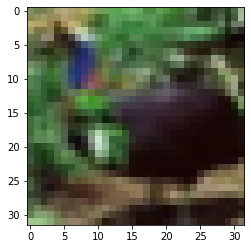

In [19]:
x = 3
y = 7
image_test = output[y*32:(y+1)*32, x*32:(x+1)*32, :]
plt.imshow(image_test)

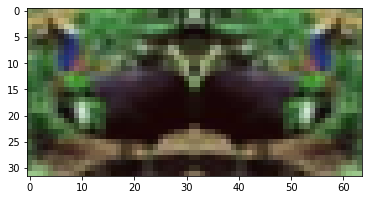

In [20]:
def flip(x):
    """
    flip image(翻轉影像)
    """
    x = tf.image.random_flip_left_right(x)  # 隨機左右翻轉影像
    return x

image_2 = flip(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

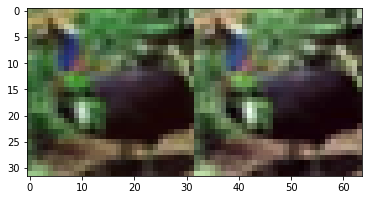

In [21]:
def color(x):
    """
     Color change(改變顏色)
    """
    x = tf.image.random_hue(x, 0.08)  # 隨機調整影像色調
    x = tf.image.random_saturation(x, 0.6, 1.6)  # 隨機調整影像飽和度
    x = tf.image.random_brightness(x, 0.05)  # 隨機調整影像亮度
    x = tf.image.random_contrast(x, 0.7, 1.3)  # 隨機調整影像對比度
    return x


image_2 = color(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

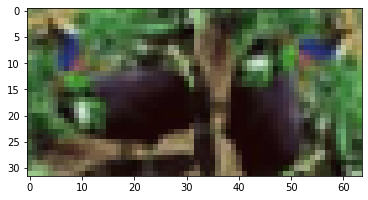

In [22]:
def rotate(x):
    """
    Rotation image(影像旋轉)
    """
    # 隨機選轉n次(通過minval和maxval設定n的範圍)，每次選轉90度
    x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32))
    return x

image_2 = rotate(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

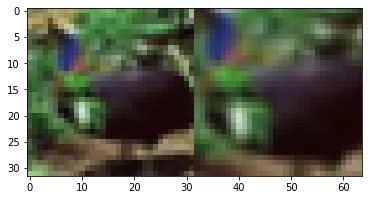

In [23]:
def zoom(x, scale_min=0.6, scale_max=1.4):
    """
    Zoom Image(影像縮放)
    """
    h, w, c = x.shape
    scale = tf.random.uniform([], scale_min, scale_max)  # 隨機縮放比例
    sh = h * scale  # 縮放後影像長度
    sw = w * scale  # 縮放後影像寬度
    x = tf.image.resize(x, (sh, sw))  # 影像縮放
    x = tf.image.resize_with_crop_or_pad(x, h, w)  # 影像裁減和填補
    return x

image_2 = zoom(image_test)
# 因為處理後影像會變成float型態，所以需轉換回來不然顯示時會出現問題
image_2 = tf.cast(image_2, dtype=tf.uint8)
image = np.hstack((image_test, image_2))  # 將原始圖和處理後水平合併
plt.imshow(image)

In [24]:
train_data = tfds.load("cifar10", split=train_split)

In [25]:
def parse_aug_fn(dataset):
    """
    Image Augmentation(影像增強) function
    """
    x = tf.cast(dataset['image'], tf.float32) / 255.  # 影像標準化
    x = flip(x)  # 隨機水平翻轉
    # 觸發顏色轉換機率50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: color(x), lambda: x)
    # 觸發影像旋轉機率0.25%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: rotate(x), lambda: x)
    # 觸發影像縮放機率50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: zoom(x), lambda: x)
    # 將輸出標籤轉乘One-hot編碼
    y = tf.one_hot(dataset['label'], 10)
    return x, y

In [26]:
# 打散資料集
train_data = train_data.shuffle(train_num)
# 載入預處理「parse_aug_fn」function，cpu數量為自動調整模式
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟（暫存空間為自動調整模式）
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

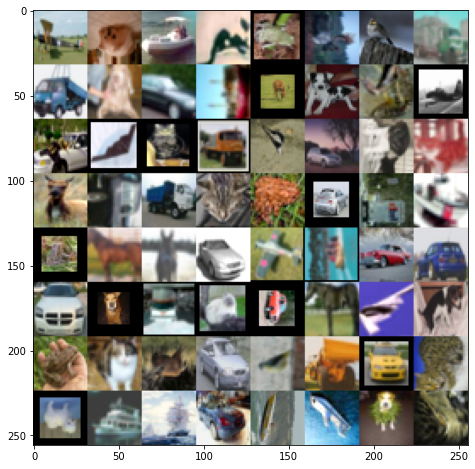

In [27]:
# 由於前面已經將train_data batch size設定為64，所以取一次資料就有64筆
for images, labels in train_data.take(1):
    images = images.numpy()
# 建立一個顯示影像的陣列
output = np.zeros((32 * 8, 32 * 8, 3))
# 將64筆資料分別放入顯示影像的陣列
for i in range(8):
    for j in range(8):
        output[i*32:(i+1)*32, j*32:(j+1)*32, :] = images[i*8+j]
plt.figure(figsize=(8, 8))
# 顯示影像
plt.imshow(output)

In [28]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_3 = keras.Model(inputs, outputs, name='model-3')
model_3.summary() 

Model: "model-3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          7379

In [29]:
log_dir = os.path.join('lab4-logs', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.hdf5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')

In [30]:
model_3.compile(keras.optimizers.Adam(), 
               loss=keras.losses.CategoricalCrossentropy(), 
               metrics=[keras.metrics.CategoricalAccuracy()])

In [31]:
history_3 = model_3.fit(train_data,
                        epochs=100, 
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp])

Epoch 1/100
704/704 [==============================] - 13s 18ms/step - loss: 2.0953 - categorical_accuracy: 0.2075 - val_loss: 1.7666 - val_categorical_accuracy: 0.3730
Epoch 2/100
704/704 [==============================] - 13s 18ms/step - loss: 1.8771 - categorical_accuracy: 0.3042 - val_loss: 1.6053 - val_categorical_accuracy: 0.4318
Epoch 3/100
704/704 [==============================] - 13s 18ms/step - loss: 1.7541 - categorical_accuracy: 0.3550 - val_loss: 1.4234 - val_categorical_accuracy: 0.4696ac
Epoch 4/100
704/704 [==============================] - 13s 18ms/step - loss: 1.6619 - categorical_accuracy: 0.3970 - val_loss: 1.3985 - val_categorical_accuracy: 0.5044
Epoch 5/100
704/704 [==============================] - 13s 18ms/step - loss: 1.5971 - categorical_accuracy: 0.4206 - val_loss: 1.2779 - val_categorical_accuracy: 0.5458 loss:
Epoch 6/100
704/704 [==============================] - 13s 18ms/step - loss: 1.5489 - categorical_accuracy: 0.4462 - val_loss: 1.2400 - val_categor

704/704 [==============================] - 13s 18ms/step - loss: 0.8277 - categorical_accuracy: 0.7235 - val_loss: 0.6599 - val_categorical_accuracy: 0.7812
Epoch 96/100
704/704 [==============================] - 13s 18ms/step - loss: 0.8218 - categorical_accuracy: 0.7259 - val_loss: 0.6276 - val_categorical_accuracy: 0.7908
Epoch 97/100
704/704 [==============================] - 13s 18ms/step - loss: 0.8289 - categorical_accuracy: 0.7222 - val_loss: 0.6286 - val_categorical_accuracy: 0.7936
Epoch 98/100
704/704 [==============================] - 13s 18ms/step - loss: 0.8212 - categorical_accuracy: 0.7262 - val_loss: 0.6522 - val_categorical_accuracy: 0.7846
Epoch 99/100
704/704 [==============================] - 13s 18ms/step - loss: 0.8266 - categorical_accuracy: 0.7235 - val_loss: 0.6515 - val_categorical_accuracy: 0.7810
Epoch 100/100
704/704 [==============================] - 13s 18ms/step - loss: 0.8243 - categorical_accuracy: 0.7263 - val_loss: 0.6375 - val_categorical_accuracy:

In [4]:
model_1.load_weights('lab4-logs/models/Best-model-1.hdf5')
model_2.load_weights('lab4-logs/models/Best-model-2.hdf5')
model_3.load_weights('lab4-logs/models/Best-model-3.hdf5')
loss_1, acc_1 = model_1.evaluate(test_data)
loss_2, acc_2 = model_2.evaluate(test_data)
loss_3, acc_3 = model_3.evaluate(test_data)

SyntaxError: invalid syntax (Temp/ipykernel_13212/3308652071.py, line 3)

In [34]:
loss = [loss_1, loss_2, loss_3]  
acc = [acc_1, acc_2, acc_3]

dict = {"Loss": loss,  
        "Accuracy": acc}

df = pd.DataFrame(dict)
df

,Loss,Accuracy
0,1.948335,0.2546
1,1.377691,0.7405
2,0.643703,0.7938


In [1]:
%load_ext tensorboard
%tensorboard --port 9540 --logdir lab4-logs